In [146]:
import skimage as img
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import filters
from skimage import exposure
from skimage import measure
import os
from skimage.filters import difference_of_gaussians, window
from scipy.fftpack import fftn, fftshift
from scipy import signal

In [2]:
# testimg = io.imread("../data/test/demo_stickweb.jpg")
testimg = io.imread("../data/test/allnoise.png")
testimg_grey = img.color.rgb2gray(testimg)
testimg_lab_l = img.color.rgb2lab(testimg)[:,:,0]

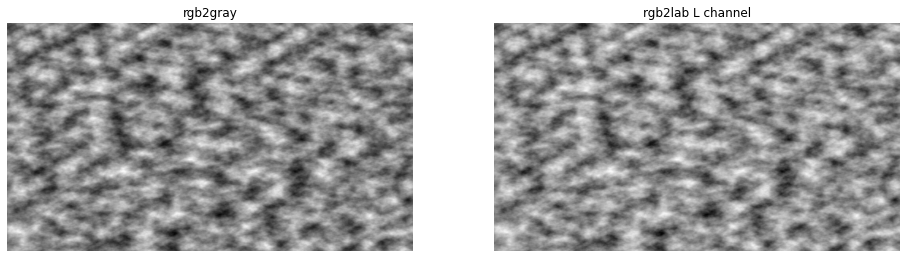

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(16,16))
ax[0].imshow(testimg_grey, cmap=plt.cm.gray) # Grayscale version
ax[1].imshow(testimg_lab_l, cmap=plt.cm.gray) # Grayscale version
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title('rgb2gray')
ax[1].set_title('rgb2lab L channel')
plt.show()

To calculate RMS Contrast:
$$\sqrt{\frac{1}{M N}\sum_{i=0}^{N-1}\sum_{j=0}^{M - 1}\left(\frac{I_{ij} - \bar{I}}{\bar{I}}\right)^2}$$

STDEV would be 

$$\sqrt{\frac{1}{M N}\sum_{i=0}^{N-1}\sum_{j=0}^{M - 1}\left(I_{ij} - \bar{I}\right)^2}$$

In [4]:
luminances = testimg_grey.flatten()
# avg_luminance = np.mean(luminances)
# rms_contrast = np.sqrt(1/len(luminances)*(sum(((luminances-avg_luminance)/avg_luminance)**2)))
# print(rms_contrast)
std_luminance = luminances.std()
print(std_luminance)

0.1303398896349521


In [5]:
measure.shannon_entropy(testimg_grey)

7.096067467172778

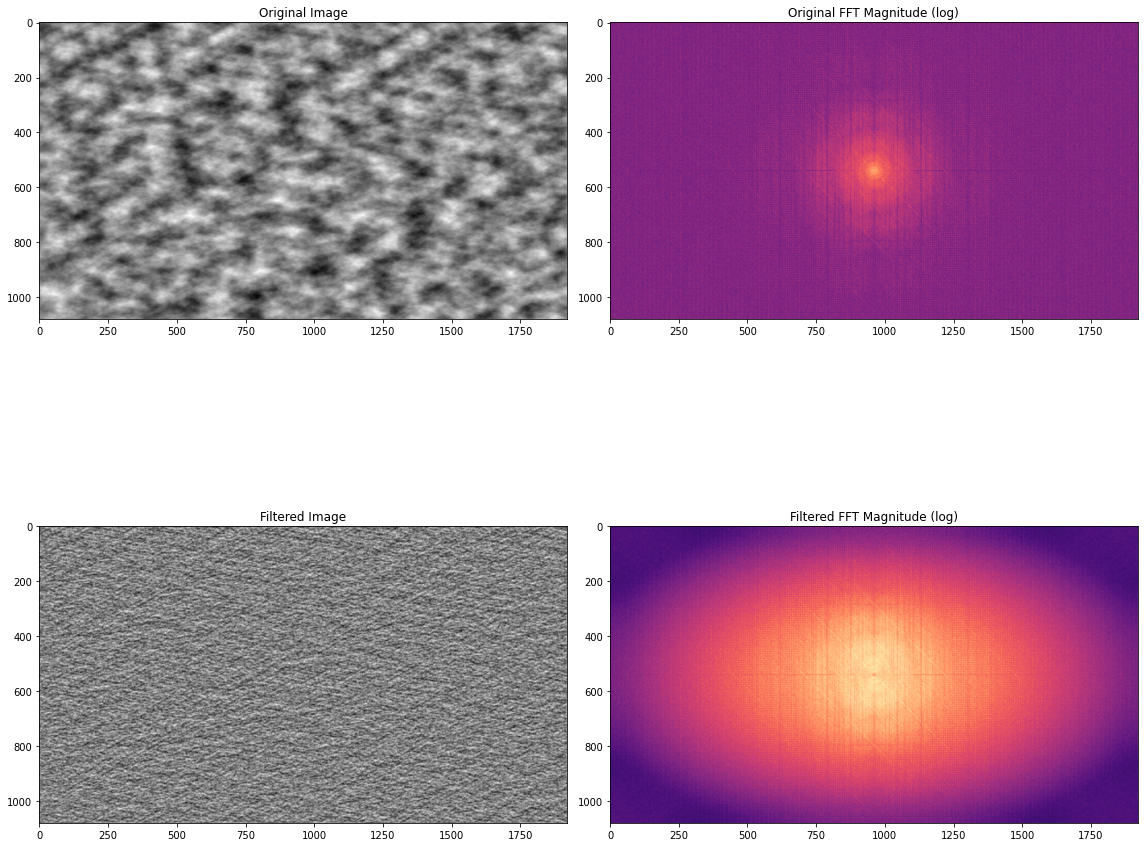

In [6]:
wimage = testimg_grey * window('hann', testimg_grey.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(testimg_grey, 1.5)
filtered_wimage = filtered_image * window('hann', testimg_grey.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax[0, 0].imshow(testimg_grey, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.tight_layout()
plt.show()

In [7]:
print(max(testimg_grey.flatten()))
print(max(filtered_image.flatten()))

0.9215686274509803
0.01721139306163566


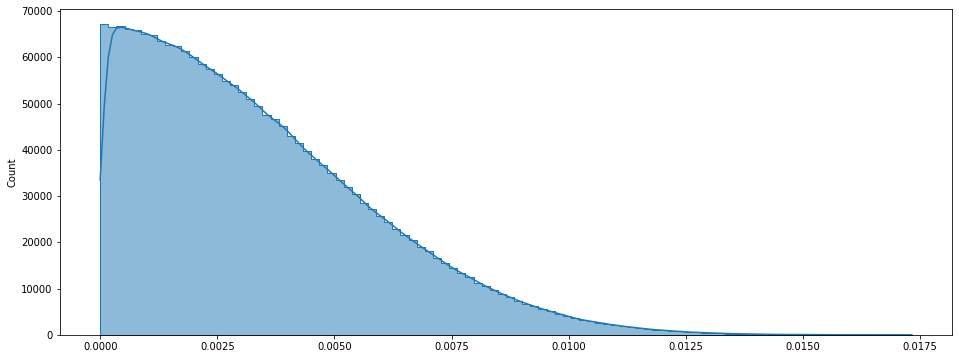

In [19]:
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.histplot(abs(filtered_image.flatten()), element='step', bins=100, kde=True)
# plt.xlim(0, 1)
plt.show()

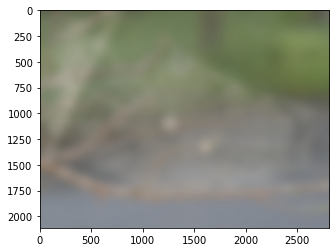

In [21]:
testimg_blur = io.imread("../data/test/demo_stickweb_blurred.jpg")
plt.imshow(testimg_blur)

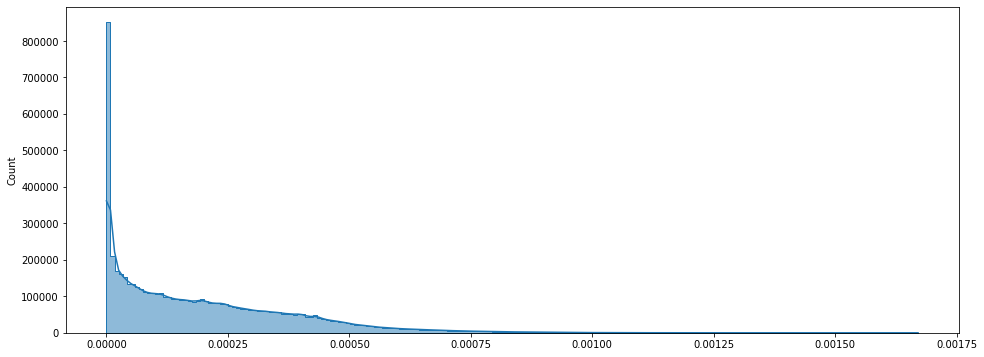

In [20]:
testimg_blur = io.imread("../data/test/demo_stickweb_blurred.jpg")
testimg_blur_grey = img.color.rgb2gray(testimg_blur)
filtered_blurred = difference_of_gaussians(testimg_blur_grey, 1.5)
plt.figure(figsize=(16, 6))
sns.histplot(abs(filtered_blurred.flatten()), element='step', bins=200, kde=True)
# plt.xlim(0, 1)
plt.show()

In [98]:
0.6500803921568628
0.0015595829395659289

0.0015595829395659289

## Quantifying spider web photo quality
There are a few major features of a "good quality" photo of a spider web that need to be fulfilled.

- High contrast (between the web and the bg)
- Low bg feature complexity (which should lead to overall low image complexity)
- Few dominant colours of a high luminosity (dark colours will likely never be the web)
- Low digitisation error rate (harder to automatically quantify)

### Finding colour peaks in image
Let's try getting the histogram of hue frequency in hsl space

In [101]:
stickweb = io.imread("../data/test/demo_stickweb.jpg")
stickweb_hsl = img.color.rgb2hsv(stickweb)

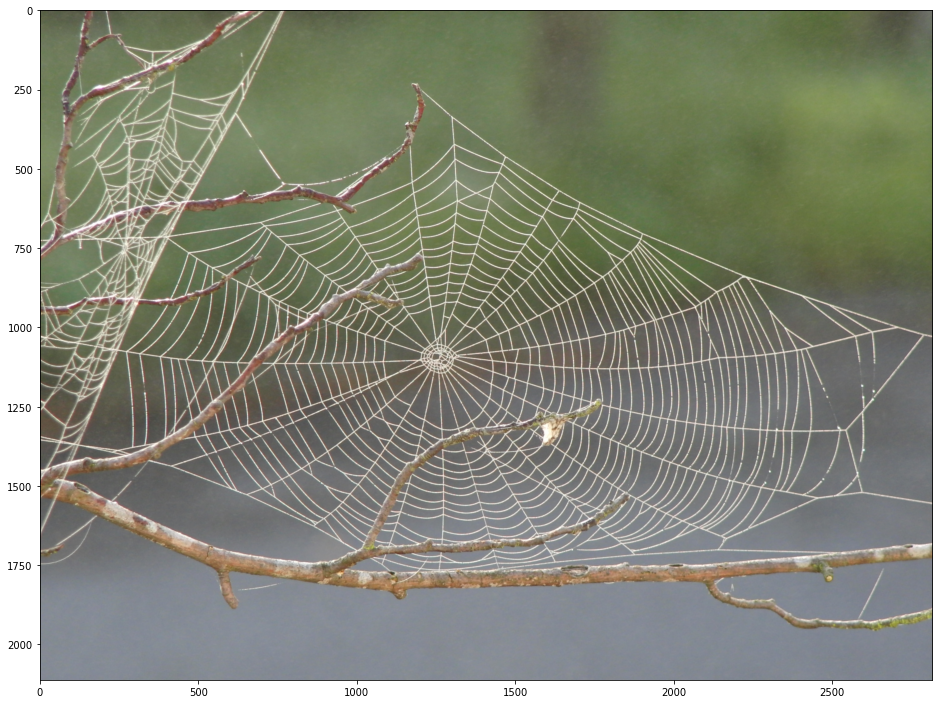

In [106]:
plt.figure(figsize=(16, 16))
plt.imshow(stickweb)
plt.show()

In [117]:
lum_vals = stickweb_hsl[:,:,2].flatten()
median_luminance = np.median(lum_vals)

# Find the upper quartile by ordering, then finding the index by 0.75 * len
upper_quartile_luminance = np.sort(lum_vals)[int(np.around(len(lum_vals) * 0.75))]

In [118]:
stickweb_mask = stickweb_hsl[:,:,2] < upper_quartile_luminance # Find low luminosity pixels
stickweb_hsl[stickweb_mask] = [0,0,0]

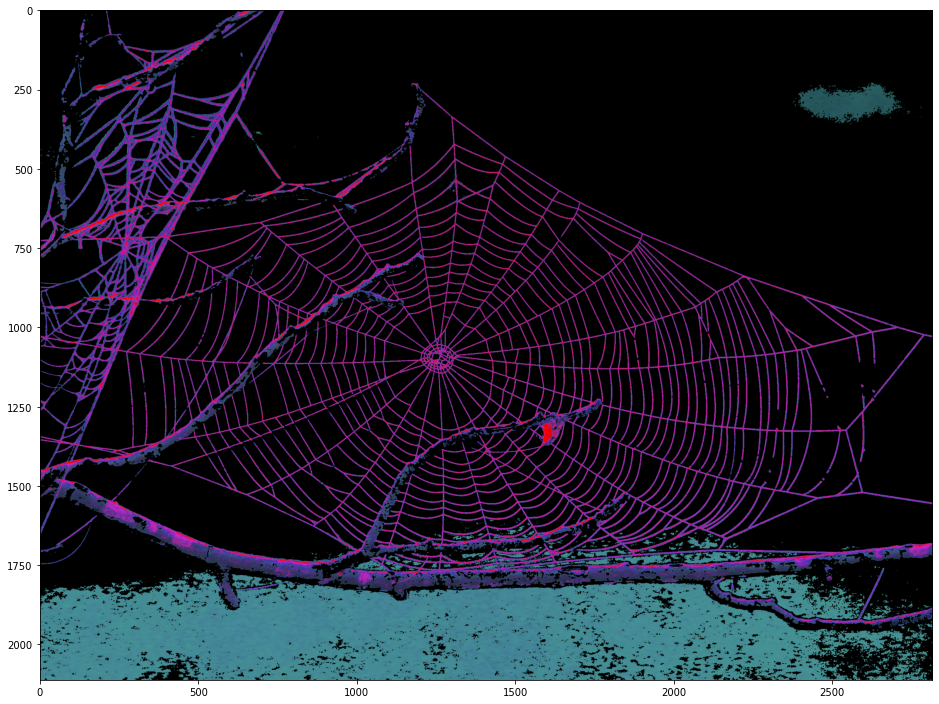

In [126]:
stickweb[stickweb_mask] = [0,0,0]
plt.figure(figsize=(16, 16))
plt.imshow(img.color.hsv2rgb(stickweb))
plt.show()
stickweb_hsl[stickweb_mask] = [np.nan,0,0]

In [120]:
flat_stickweb = stickweb_hsl[:,:,0].flatten()
print(flat_stickweb.shape)

flat_stickweb = flat_stickweb[~np.isnan(flat_stickweb)]
(flat_stickweb.shape)

(5947392,)


(1549376,)

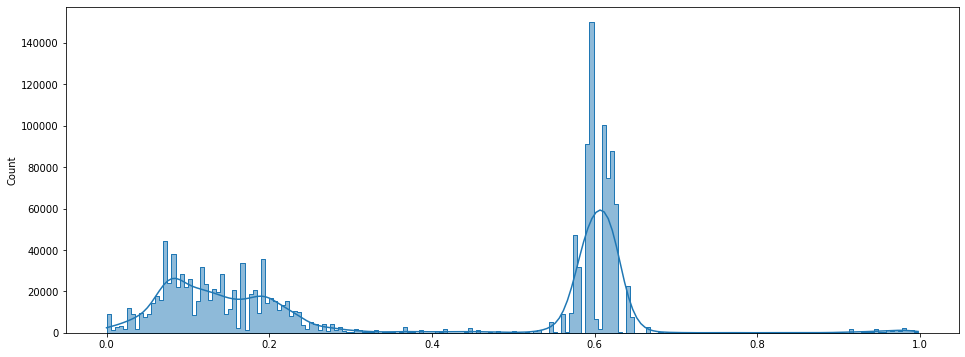

In [121]:
plt.figure(figsize=(16, 6))
sns.histplot(flat_stickweb, element='step', bins=200, kde=True)
# plt.xlim(0, 1)
plt.show()

[]

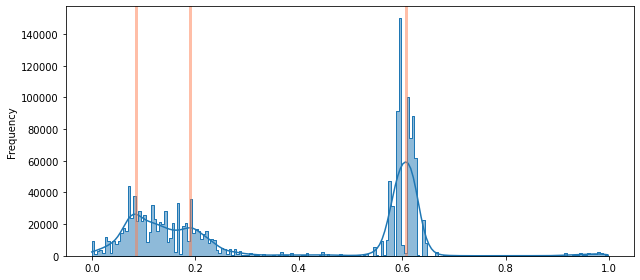

In [185]:
fig, ax = plt.subplots(figsize=(9,4))
# Extract data out of hist plot
data = sns.histplot(flat_stickweb, element='step', bins=200, kde=True, ax=ax).get_lines()[0].get_data()

# Find peaks in frequency and associated hues
peak_idxs = signal.find_peaks(data[1], height=max(data[1]/4))[0]
peak_hues = data[0][peak_idxs]

# Plot peaks
for peak in peak_hues:
    ax.axvline(peak, color="#FF7F50", lw=3, alpha=0.5)

# ax.set_xlim(0,max(summary_dict["mesh_measurements"])*0.4)

# ax.text(x=summary_dict["mw_median"]-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

# ax.axvline(summary_dict["mw_mean"], color="royalblue", lw=3, alpha=0.5)
# ax.text(x=summary_dict["mw_mean"], y=0.069, s='Mean', alpha=1, color='royalblue')
# ax.axvline(700, color="#FF7F50")
#     a.axvline(750, color="green")

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

### Test on random rgb noise

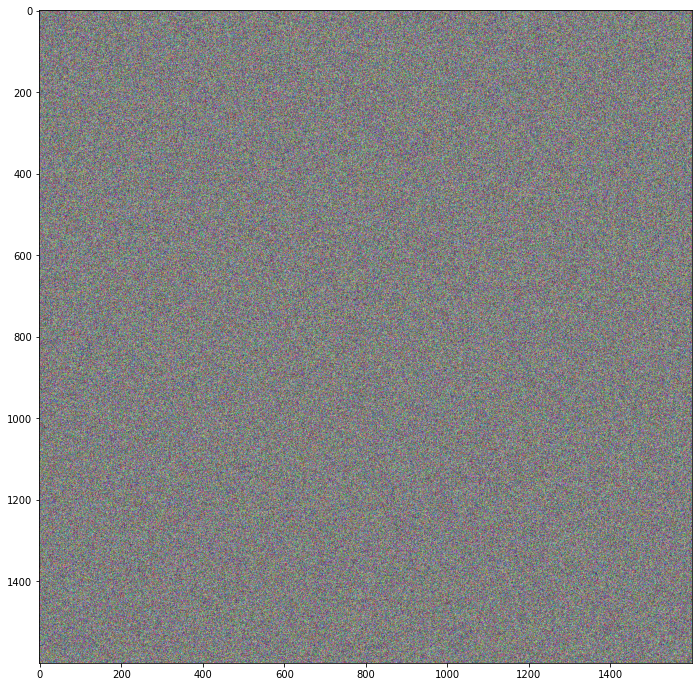

In [176]:
rng = np.random.default_rng()
size = 1600
noise_pixels = rng.random((size, size, 3))

# noise_pixels[rng.integers(0,2,size=(size, size)).astype(np.bool) * rng.integers(0,2,size=(size, size)).astype(np.bool) * rng.integers(0,2,size=(size, size)).astype(np.bool)] = [0,1,0]

plt.figure(figsize=(12, 12))
plt.imshow(noise_pixels)
plt.show()

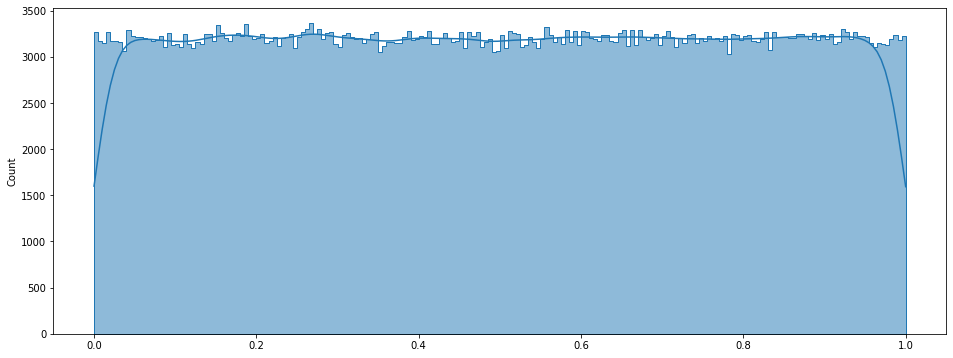

In [177]:
noise_pixels_hsl = img.color.rgb2hsv(noise_pixels)

lum_vals = noise_pixels_hsl[:,:,2].flatten()
median_luminance = np.median(lum_vals)

# Find the upper quartile by ordering, then finding the index by 0.75 * len
upper_quartile_luminance = np.sort(lum_vals)[int(np.around(len(lum_vals) * 0.75))]

noise_pixels_mask = noise_pixels_hsl[:,:,2] < upper_quartile_luminance # Find low luminosity pixels
noise_pixels_hsl[noise_pixels_mask] = [np.nan,0,0]

flat_noise_pixels = noise_pixels_hsl[:,:,0].flatten()

flat_noise_pixels = flat_noise_pixels[~np.isnan(flat_noise_pixels)]

plt.figure(figsize=(16, 6))
sns.histplot(flat_noise_pixels, element='step', bins=200, kde=True)
# plt.xlim(0, 1)
plt.show()

[]

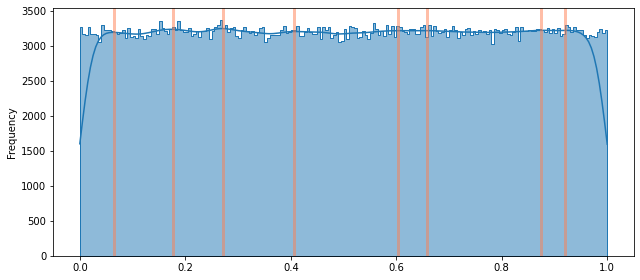

In [182]:
fig, ax = plt.subplots(figsize=(9,4))
data = sns.histplot(flat_noise_pixels, element='step', bins=200, kde=True, ax=ax).get_lines()[0].get_data()
peak_idxs = signal.find_peaks(data[1], height=max(data[1]/4))[0]
peak_hues = data[0][peak_idxs]

for peak in peak_hues:
    ax.axvline(peak, color="#FF7F50", lw=3, alpha=0.5)

# ax.set_xlim(0,max(summary_dict["mesh_measurements"])*0.4)

# ax.text(x=summary_dict["mw_median"]-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

# ax.axvline(summary_dict["mw_mean"], color="royalblue", lw=3, alpha=0.5)
# ax.text(x=summary_dict["mw_mean"], y=0.069, s='Mean', alpha=1, color='royalblue')
# ax.axvline(700, color="#FF7F50")
#     a.axvline(750, color="green")

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

## How about some contrast?
Let's start by just looking at simple rms contrast as above

In [188]:
stickweb = io.imread("../data/test/demo_stickweb.jpg")
stickweb_grey = img.color.rgb2gray(stickweb)

stickweb_std = stickweb_grey.flatten().std()
stickweb_std

0.1154619137276712

0.2163626049927572


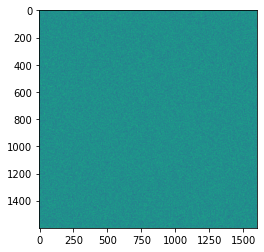

In [191]:
noise_pixels_grey = img.color.rgb2gray(noise_pixels)
noise_pixels_std = noise_pixels_grey.flatten().std()
print(noise_pixels_std)
plt.imshow(noise_pixels_grey)